In [2]:
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/DF_GMVI.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/WALNUTS.jl")
include("./MultiModal.jl")
Random.seed!(111);

## Gaussian mixture

We test GMBBVI with Gaussian mixture target densities

$$
\rho_{\rm post}(\theta) = \sum_{i=1}^K w_i \mathcal{N}(\theta; m_i, C_i) \propto e^{-\Phi_r(\theta)} ,\qquad
\Phi_r(\theta) = - \log\Bigl( \sum_{i=1}^K w_i \mathcal{N}(\theta; m_i, C_i) \Bigr).
$$


## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Neal’s funnel

Consider the following distribution defined over $\theta = (w,x)$ with $w \in \mathbb{R}$ and $x = (x_1,\ldots,x_{d-1}) \in \mathbb{R}^{d-1}$ where
$$
w \sim \mathcal{N}(0,9), \quad x_i \vert w \sim \mathcal{N}(0,\exp(w)).
$$

In [3]:
# 新增辅助函数：计算高斯混合模型的期望和协方差
function calculate_gm_stats(weights, means, covs)
    # 确保权重归一化
    w = weights / sum(weights)
    N_modes, N_θ = size(means)

    # 计算总期望 (mean)
    total_mean = zeros(N_θ)
    for i in 1:N_modes
        total_mean += w[i] * means[i, :]
    end

    # 计算总协方差 (variance)
    # Cov[X] = E[Cov[X|Z]] + Cov[E[X|Z]]
    # E[Cov[X|Z]] = Σ(w_i * Σ_i)
    # Cov[E[X|Z]] = Σ(w_i * μ_i * μ_i') - E[X]E[X]'
    e_cov = zeros(N_θ, N_θ)
    cov_e = zeros(N_θ, N_θ)
    for i in 1:N_modes
        e_cov += w[i] * covs[i, :, :]
        cov_e += w[i] * (means[i, :] * means[i, :]')
    end
    total_cov = e_cov + cov_e - (total_mean * total_mean')
    
    return total_mean, total_cov
end

# 新增辅助函数：计算样本的期望和协方差
function calculate_sample_stats(samples)
    # samples: N_θ x N_samples
    if isempty(samples) || size(samples, 2) < 2
        return fill(NaN, size(samples, 1)), fill(NaN, size(samples, 1), size(samples, 1))
    end
    # 使用 Statistics.mean 和 Statistics.cov
    total_mean = mean(samples, dims=2)[:, 1]
    total_cov = cov(samples') # cov 需要变量在列上，所以转置
    return total_mean, total_cov
end
        
        
function visualization_comparison_nd(ax, ens_WALNUTS = nothing, obj_DF_GMVI = nothing, obj_GMBBVI= nothing; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
    func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)
    
    x_min, x_max = x_lim
    y_min, y_max = y_lim
    boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

    Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    if ens_WALNUTS!=nothing
        error = zeros(N_iter+1)
        
        boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
            samples_per_iter = 300
            total_samples = size(ens_WALNUTS, 2)
            for iter = 0:N_iter
                n_samples_end = min((iter + 1) * samples_per_iter, total_samples)
                if n_samples_end < 2
                    error[iter+1] = NaN
                    continue
                end
                samples_iter = ens_WALNUTS[1:2, Int(n_samples_end/2):n_samples_end]

                if bandwidth==nothing
                    kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny))
                else
                    kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                end
        
                Z = kde_iter.density
                sum_Z = sum(Z)
                if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                error[iter+1] = norm(Z - Z_ref,1)*dx*dy
            end
        ax[6].semilogy(Array(0:N_iter), error, label="WALNUTS")

        function plot_mcmc_on_ax(ax_plt, samples, title)
            if samples === nothing || size(samples, 2) < 20
                ax_plt.text(0.5, 0.5, "No Samples", ha="center", va="center")
                # ax_plt.set_title(title)
                ax_plt.set_xlim(x_lim)
                ax_plt.set_ylim(y_lim)
                return
            end

        #     ax_plt.set_title(title)

            burn_in = div(size(samples, 2), 2)
            samples_to_plot = samples[1:2, burn_in+1:end]

            if size(samples_to_plot, 2) < 2
                ax_plt.text(0.5, 0.5, "No Samples Post Burn-in", ha="center", va="center")
                return
            end

            kde_boundary = ((x_lim[1], x_lim[2]), (y_lim[1], y_lim[2]))

            kde_res = kde(samples_to_plot', boundary=kde_boundary, npoints=(Nx, Ny), bandwidth=bandwidth)
            Z_kde = kde_res.density
            if sum(Z_kde) > 0 Z_kde ./= sum(Z_kde) * dx * dy end
            ax_plt.pcolormesh(X, Y, Z_kde, cmap="viridis", vmin=color_lim[1], vmax=color_lim[2])

            alpha_val = min(1.0, 100 / size(samples_to_plot, 2))
            ax_plt.scatter(samples_to_plot[1, :], samples_to_plot[2, :], 
            marker=".", color="red", s=10, alpha=alpha_val)

            mean_val, cov_val = calculate_sample_stats(samples_to_plot)

            if !any(isnan, mean_val) && !any(isnan, cov_val)
                text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                ax_plt.text(0.05, 0.95, text_str, transform=ax_plt.transAxes, fontsize=8,
                    verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
            end

            ax_plt.set_xlim(x_lim)
            ax_plt.set_ylim(y_lim)
        end

        plot_mcmc_on_ax(ax[2], ens_WALNUTS, "WALNUTS")
    end

    if obj_DF_GMVI!=nothing
        error = zeros(N_iter+1)
        
        obj = obj_DF_GMVI
        for iter = 0:N_iter
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1][:,1:2]
            xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[iter+1] = norm(Z - Z_ref,1)*dx*dy
            if iter == N_iter
            
                ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[3].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[3].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                ax[3].text(0.05, 0.95, text_str, transform=ax[3].transAxes, fontsize=8,
                        verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
            
            end
        end
        
        ax[6].semilogy(Array(0:N_iter), error, label="DF_GMVI") 
    end



    if obj_GMBBVI !=nothing
        error = zeros(length(obj_GMBBVI),N_iter+1)
        for (i, obj) in enumerate(obj_GMBBVI)
            for iter = 0:N_iter
                x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj.x_mean[iter+1][:,1:2]
                xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[i, iter+1] = norm(Z - Z_ref,1)*dx*dy
                if iter == N_iter
                
                    ax[i+3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                    ax[i+3].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                    ax[i+3].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                    mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                    text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                    ax[i+3].text(0.05, 0.95, text_str, transform=ax[i+3].transAxes, fontsize=8,
                        verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                
                end
            end
        end
        label = ["J="*string(obj.N_ens)  for obj in obj_GMBBVI ]
        ax[6].semilogy(Array(0:N_iter), error', label=label) 
    end

    
      
    
    if make_label==true  ax[6].legend()  end

    ymin, ymax = ax[6].get_ylim()

    # Ensure the lower bound of y-ticks is below 0.1
    if ymin > 0.1 && ymin < 0.5
        ax[6].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    end

end




visualization_comparison_nd (generic function with 4 methods)

# Test the aforementioned examples with different methods

In [6]:
function log_Gaussian_mixture(x, args)
    x_w, x_mean, inv_sqrt_x_cov = args
    # C = L L.T
    # C^-1 = L^-TL^-1
    N_x = size(x_mean, 2)
    ρ = 0
    exponents = [-0.5*(x-x_mean[im,:])'*(inv_sqrt_x_cov[im]'*inv_sqrt_x_cov[im]*(x-x_mean[im,:])) for im =1:length(x_w)]
    mexponent = maximum(exponents)
    for im = 1:length(x_w)
        ρ += x_w[im]*exp(exponents[im] - mexponent)*det(inv_sqrt_x_cov[im])
    end
    return  log(ρ) + mexponent - N_x/2*log(2*π)
end

function MultiModel_GMBBVI_Test(N_x, N_iter, N_modes)
    Random.seed!(111);
    fig, ax = PyPlot.subplots(nrows=5, ncols=6, sharex=false, sharey=false, figsize=(20,20))
    
    # Problem setup
    Nx, Ny = 100, 100
    fig.suptitle("Dim = "*string(N_x))
    x0_w  = ones(N_modes)/N_modes
    N_ens_array = [2*N_x, 5*N_x]
    N_ens_max = N_ens_array[end]
    # N_ens_WALNUTS = 1000
    x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
    μ0, Σ0 = zeros(N_x), Diagonal(ones(N_x))
    for im = 1:N_modes
        x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
        xx0_cov[im, :, :] .= Σ0
    end
    dt_BBVI = 1.0 
    dt_DF_GMVI = 0.5

    # Gaussian_mixture
    N_modes_GM = 3
    x_w_ref = rand(Uniform(0,1), N_modes_GM) 
    x_w_ref = x_w_ref/sum(x_w_ref)
    x_mean_ref = 3.0*rand(Normal(0, 1), (N_modes_GM, N_x))
    xx_cov_ref = zeros(N_modes_GM, N_x, N_x)
    inv_sqrt_xx_cov_ref = []
    inv_sqrt_xx_cov_ref_marginal = []
    for i = 1:N_modes_GM
        W = rand(Normal(0, 1), (N_x, N_x))
        xx_cov_ref[i,:,:] = 0.25*(W'*W/N_x + I)/2.0
        push!(inv_sqrt_xx_cov_ref, inv(cholesky(xx_cov_ref[i,:,:]).L))
        push!(inv_sqrt_xx_cov_ref_marginal, inv(cholesky(xx_cov_ref[i,1:2,1:2]).L))
    end
    func_Phi(x) = -log_Gaussian_mixture(x, (x_w_ref, x_mean_ref, inv_sqrt_xx_cov_ref))
    func_dPhi(θ) = ForwardDiff.gradient(x -> func_Phi(x), θ)
    func_Phi_marginal(x) = -log_Gaussian_mixture(x, (x_w_ref, x_mean_ref[:,1:2], inv_sqrt_xx_cov_ref_marginal))
    # func_F(x) = 

    t0 = time()
    ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, func_dPhi; N_iter = N_iter*300, h=0.4, δ=0.4)
    t1 = time()
    obj_DF_GMVI = nothing
    # obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_DF_GMVI)[1] 
    t2 = time()
    GMBBVI = [Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_BBVI, N_ens=N_ens)
            for N_ens in N_ens_array]
    t3 = time()
    @info "WALNUTS time = ", t1 - t0, "DF_GMVI time = ", t2 - t1, "GMBBVI time = ", t3 - t2
    visualization_comparison_nd(ax[1, :], ens_WALNUTS, obj_DF_GMVI, GMBBVI; Nx = Nx, Ny = Ny, x_lim=[-10.0, 10.0], y_lim=[-10.0, 10.0], func_Phi=func_Phi_marginal, 
        bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)

    
    # Circle
    Gtype = "Circle"
    ση = [0.3; ones(N_x-2)]
    A = [1.0 0.0; 0.0 1.0]
    y = [1.0; zeros(N_x-2)]
    func_args = (y, ση, A, Gtype)
    func_marginal_args = (y[1:1], ση[1:1], A , Gtype)
    func_F(x) = F(x, func_args)
    func_F_marginal(x) = F(x, func_marginal_args)
    func_Phi = x -> Phi(x, func_args)
    func_dPhi(θ) = ForwardDiff.gradient(x -> func_Phi(x), θ)
    
    t0 = time()
    ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, func_dPhi; N_iter = N_iter*300, h=0.3, δ=0.2)
    t1 = time()
    obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_DF_GMVI)[1] 
    t2 = time()
    GMBBVI = [Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_BBVI, N_ens=N_ens)
            for N_ens in N_ens_array]
    t3 = time()
    @info "WALNUTS time = ", t1 - t0, "DF_GMVI time = ", t2 - t1, "GMBBVI time = ", t3 - t2
    visualization_comparison_nd(ax[2, :], ens_WALNUTS, obj_DF_GMVI, GMBBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
        bandwidth=(0.10,0.10), make_label=true,  N_iter= N_iter)

    
    # Banana
    Gtype = "Banana"
    ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
    λ = 10.0
    y = [0.0; 1.0; zeros(N_x-2)]
    func_args = (y, ση, λ , Gtype)
    func_marginal_args = (y[1:2], ση[1:2], λ, Gtype)
    func_F(x) = F(x, func_args)
    func_F_marginal(x) = F(x, func_marginal_args)
    func_Phi = x -> Phi(x, func_args)
    func_dPhi(θ) = ForwardDiff.gradient(x -> func_Phi(x), θ)
    
    t0 = time()
    ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, func_dPhi; N_iter = N_iter*300, h=0.6, δ=0.7)
    t1 = time()
    obj_DF_GMVI = nothing
    obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_DF_GMVI)[1] 
    t2 = time()
    GMBBVI = nothing
    GMBBVI = [Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_BBVI, N_ens=N_ens)
            for N_ens in N_ens_array]
    t3 = time()
    @info "WALNUTS time = ", t1 - t0, "DF_GMVI time = ", t2 - t1, "GMBBVI time = ", t3 - t2
    visualization_comparison_nd(ax[3, :], ens_WALNUTS, obj_DF_GMVI, GMBBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], func_F=func_F_marginal, 
        bandwidth=(0.05,0.10), make_label=true,  N_iter= N_iter)
    
    
    # Neal's funnel
    Gtype = "Funnel"
    ση = ones(N_x)
    A = Diagonal(ones(N_x-1))
    y = zeros(N_x)
    func_args = (y, ση, A, Gtype)
    func_marginal_args = (y[1:2], ση[1:2], A[1,1], Gtype)
    func_F(x) = F(x, func_args)
    func_F_marginal(x) = F(x, func_marginal_args)
    func_Phi = x -> Phi(x, func_args)
    func_dPhi(θ) = ForwardDiff.gradient(x -> func_Phi(x), θ)
    
    t0 = time()
    ens_WALNUTS = Run_WALNUTS(μ0, func_Phi, func_dPhi; N_iter = N_iter*300, h=0.36, δ=0.21)
    t1 = time()
    obj_DF_GMVI = nothing
    obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt_DF_GMVI)[1] 
    t2 = time()
    GMBBVI = nothing
    GMBBVI = [Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 0.5, N_ens=N_ens)
            for N_ens in N_ens_array]
    t3 = time()
    @info "WALNUTS time = ", t1 - t0, "DF_GMVI time = ", t2 - t1, "GMBBVI time = ", t3 - t2
    visualization_comparison_nd(ax[4, :], ens_WALNUTS, obj_DF_GMVI, GMBBVI; Nx = Nx, Ny = Ny, x_lim=[-10.0, 5.0], y_lim=[-15.0, 15.0], func_F=func_F_marginal, 
        bandwidth=(0.35, 0.10), make_label=true,  N_iter= N_iter)
        
    fig.savefig("MultiModal-GMBBVI-"*string(N_x)*"D.pdf")
end


MultiModel_GMBBVI_Test (generic function with 1 method)

## 10 dimensional problems

[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("WALNUTS time = ", 64.13300013542175, "DF_GMVI time = ", 0.0, "GMBBVI time = ", 19.0479998588562)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = 

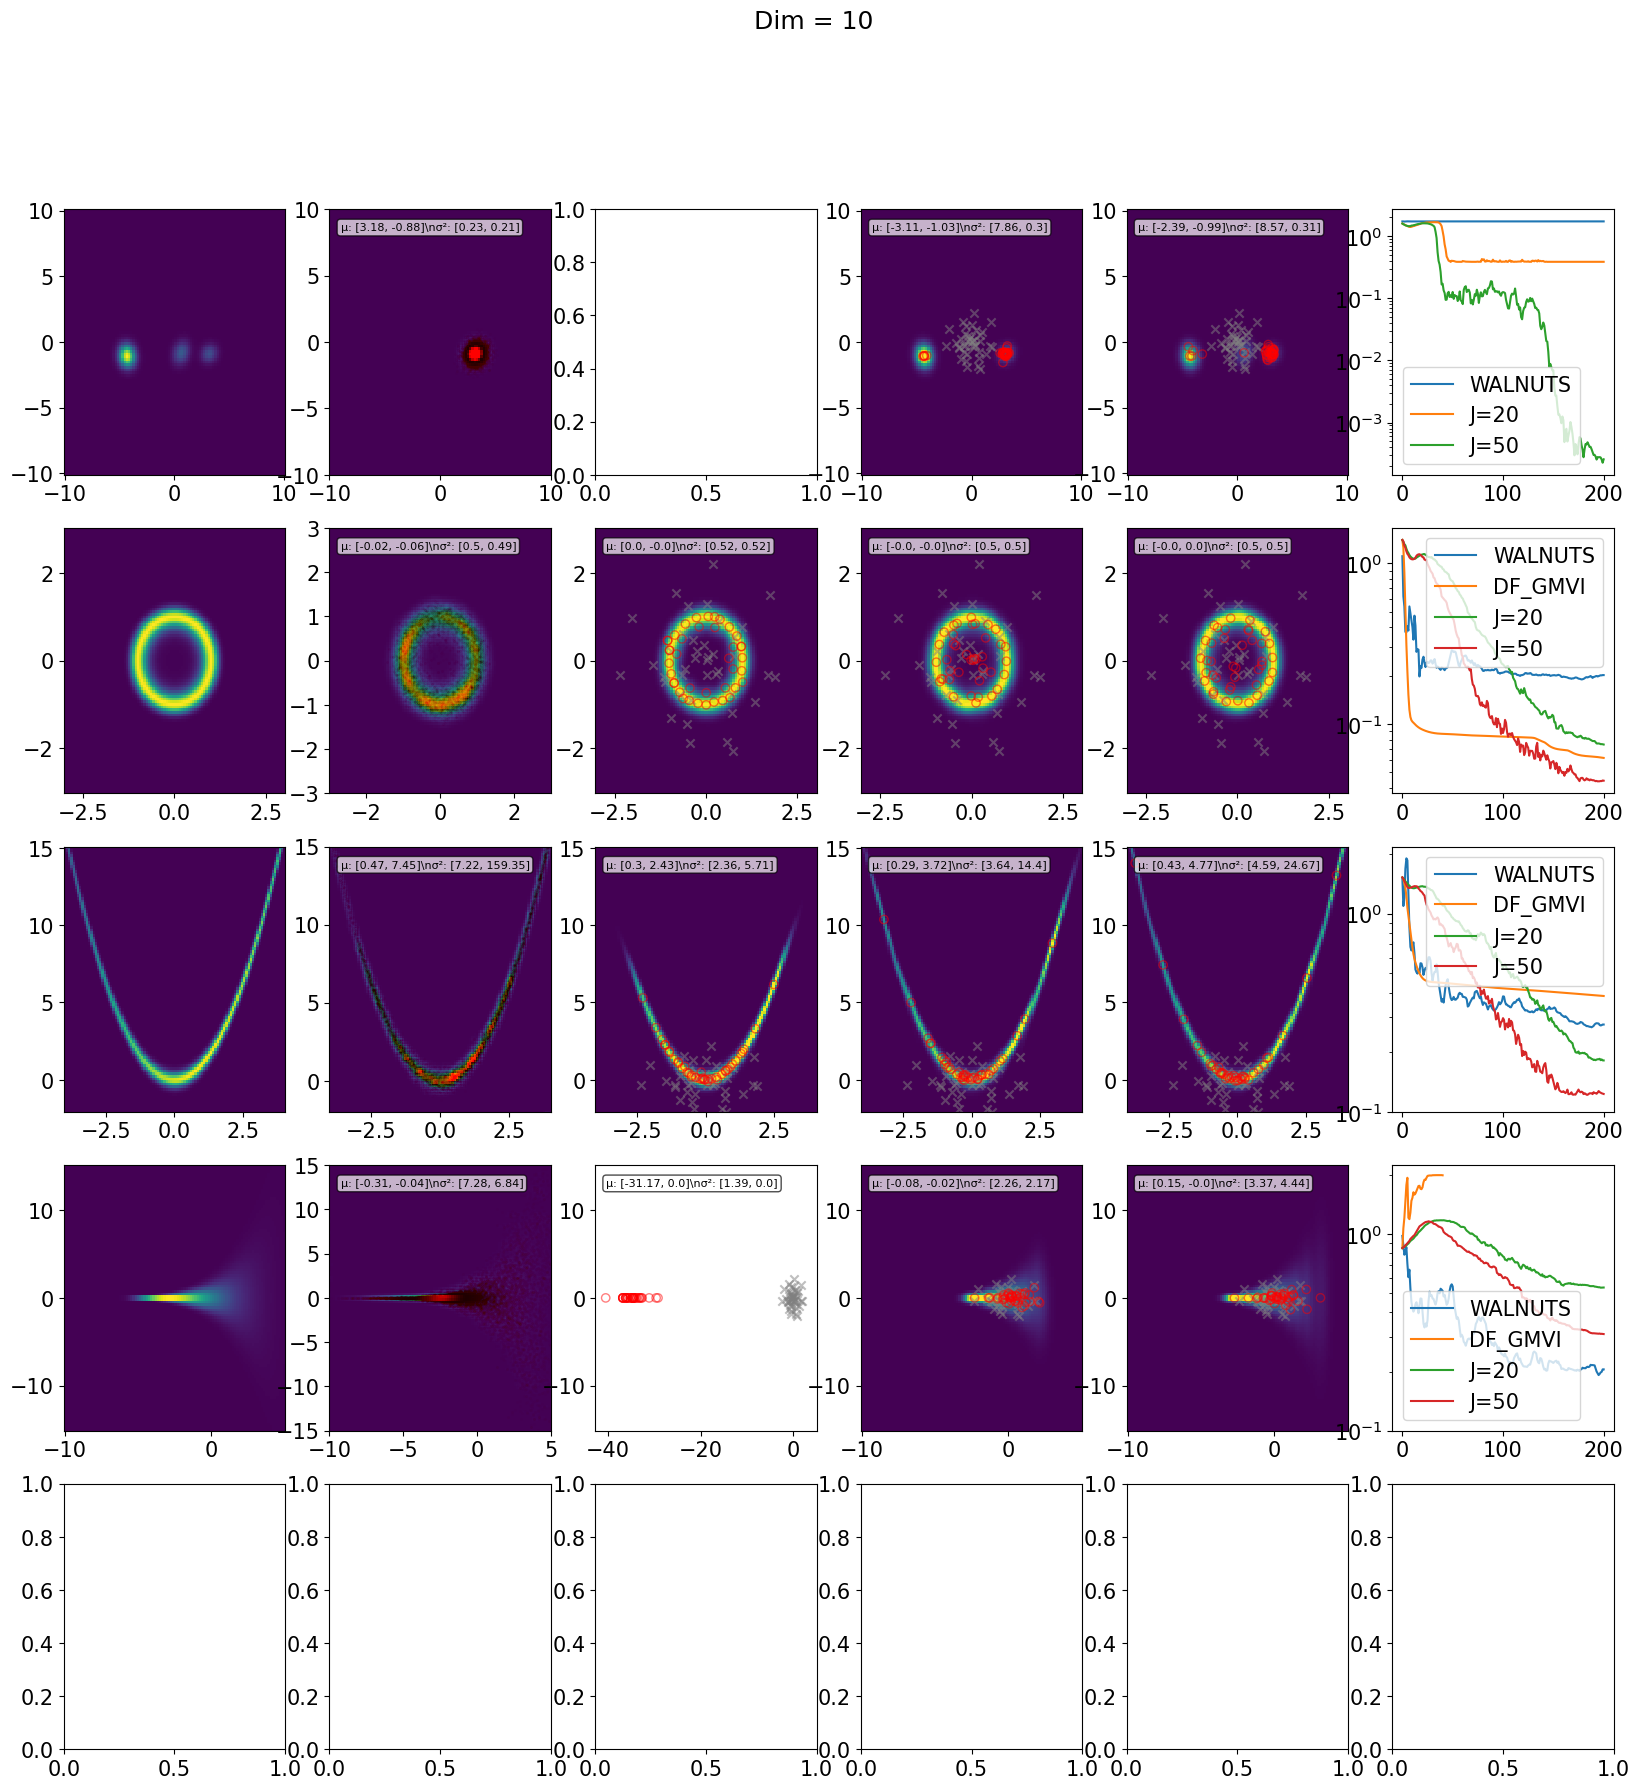

In [10]:
N_x, N_iter, N_modes = 10, 200, 40
MultiModel_GMBBVI_Test(N_x, N_iter, N_modes)

## 100 dimensional problems

In [ ]:
N_x, N_iter, N_modes = 100, 200, 40
MultiModel_GMBBVI_Test(N_x, N_iter, N_modes)